# LLM Serving 프레임워크 성능 비교: Ollama vs vLLM vs SGLang

### 비교 항목

1. **응답 지연 시간(Latency)**: 단일 요청의 처리 속도
2. **처리량(Throughput)**: 단위 시간당 처리 가능한 요청 수
3. **토큰 생성 속도**: 초당 생성되는 토큰 수
4. **메모리 사용량**: 모델 실행 시 메모리 효율성
5. **배치 처리 성능**: 여러 요청 동시 처리 능력
6. **캐시 효율성**: 유사 프롬프트 재사용 시 성능 향상
7. **확장성**: 부하 증가에 따른 성능 변화

### 테스트 환경

- 모델: gpt-oss-20b (모든 프레임워크 동일)
- 프롬프트: 다양한 길이와 복잡도
- 측정 방법: 각 시나리오당 10회 반복 측정 후 평균

## 1. 환경 설정 및 라이브러리 설치

In [10]:
# 필요한 라이브러리 설치
#%pip install -q matplotlib psutil

In [1]:
import time
import json
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import psutil
from typing import List, Dict, Any
from openai import OpenAI
import concurrent.futures
from datetime import datetime

# 한글 폰트 설정 (matplotlib)
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

# 결과 저장을 위한 딕셔너리
results = {
    'ollama': {},
    'vllm': {},
    'sglang': {}
}

print("라이브러리 로딩 완료")

라이브러리 로딩 완료


## 2. 클라이언트 설정

각 프레임워크에 연결하는 클라이언트를 설정한다.

In [2]:
# Ollama 설정
OLLAMA_BASE_URL = "http://localhost:11434"
OLLAMA_MODEL = "gpt-oss:20b"

# vLLM 설정
vllm_client = OpenAI(
    base_url="http://localhost:8001/v1",
    api_key="EMPTY"
)
VLLM_MODEL = "openai/gpt-oss-20b"

# SGLang 설정
import sglang as sgl
sgl_runtime = sgl.Runtime(
    model_path="openai/gpt-oss-20b",
)
sgl.set_default_backend(sgl_runtime)

print("클라이언트 설정 완료")
print(f"Ollama: {OLLAMA_BASE_URL}")
print(f"vLLM: vllm_client.base_url")
print(f"SGLang: http://localhost:30000")

/home/josh/anaconda3/envs/lecture/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


INFO 11-18 10:51:52 [__init__.py:216] Automatically detected platform cuda.


[2025-11-18 10:51:54] INFO model_config.py:885: Downcasting torch.float32 to torch.float16.
[2025-11-18 10:51:54] WARNING model_config.py:724: mxfp4 quantization is not fully optimized yet. The speed can be slower than non-quantized models.
[2025-11-18 10:51:54] WARNING server_args.py:1017: Detected GPT-OSS model, enabling triton_kernels MOE kernel.


INFO 11-18 10:52:00 [__init__.py:216] Automatically detected platform cuda.
INFO 11-18 10:52:12 [__init__.py:216] Automatically detected platform cuda.
INFO 11-18 10:52:13 [__init__.py:216] Automatically detected platform cuda.
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0
[Gloo] Rank 0 is connected to 0 peer ranks. Expected number of connected peer ranks is : 0


`torch_dtype` is deprecated! Use `dtype` instead!
Loading safetensors checkpoint shards:   0% Completed | 0/3 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 3/3 [00:00<00:00, 101.71it/s]

Capturing batches (bs=1 avail_mem=10.06 GB): 100%|██████████| 36/36 [00:13<00:00,  2.73it/s]  


클라이언트 설정 완료
Ollama: http://localhost:11434
vLLM: vllm_client.base_url
SGLang: http://localhost:30000


## 3. 테스트 프롬프트 준비

다양한 길이와 복잡도의 프롬프트를 준비한다.

In [3]:
# 짧은 프롬프트 (10-20 토큰)
short_prompts = [
    "Python이란 무엇인가?",
    "머신러닝의 정의는?",
    "클라우드 컴퓨팅을 설명하시오.",
    "인공지능의 역사는?",
    "데이터베이스란 무엇인가?"
]

# 중간 프롬프트 (50-100 토큰)
medium_prompts = [
    "Python 프로그래밍 언어의 주요 특징과 장점을 설명하고, 어떤 분야에서 주로 사용되는지 예시를 들어 설명하시오.",
    "머신러닝과 딥러닝의 차이점을 설명하고, 각각의 대표적인 알고리즘을 3가지씩 나열하시오.",
    "클라우드 컴퓨팅의 세 가지 주요 서비스 모델(IaaS, PaaS, SaaS)의 특징과 차이점을 설명하시오.",
    "자연어 처리(NLP)의 주요 응용 분야를 설명하고, 각 분야에서 사용되는 기술을 간단히 소개하시오.",
    "데이터베이스 정규화의 개념과 제1정규형, 제2정규형, 제3정규형의 특징을 설명하시오."
]

# 긴 프롬프트 (200+ 토큰)
long_prompts = [
    """Python 프로그래밍 언어가 현대 소프트웨어 개발에서 중요한 위치를 차지하게 된 이유를 다음 측면에서 상세히 분석하시오:
    1) 언어 설계 철학과 문법적 특징
    2) 풍부한 라이브러리 생태계
    3) 다양한 응용 분야 (웹 개발, 데이터 과학, AI/ML, 자동화 등)
    4) 커뮤니티와 교육 자료의 접근성
    5) 다른 언어들과의 비교 우위
    각 측면에서 구체적인 예시와 함께 설명하고, Python의 한계점도 함께 논의하시오.""",
    
    """딥러닝 모델의 학습 과정을 다음 단계로 나누어 상세히 설명하시오:
    1) 데이터 전처리와 증강 기법
    2) 모델 아키텍처 설계 (CNN, RNN, Transformer 등)
    3) 손실 함수와 최적화 알고리즘 선택
    4) 학습률 스케줄링과 정규화 기법
    5) 검증과 평가 지표
    6) 하이퍼파라미터 튜닝 방법
    각 단계에서 고려해야 할 사항과 모범 사례를 포함하여 설명하시오."""
]

print(f"테스트 프롬프트 준비 완료")
print(f"- 짧은 프롬프트: {len(short_prompts)}개")
print(f"- 중간 프롬프트: {len(medium_prompts)}개")
print(f"- 긴 프롬프트: {len(long_prompts)}개")

테스트 프롬프트 준비 완료
- 짧은 프롬프트: 5개
- 중간 프롬프트: 5개
- 긴 프롬프트: 2개


## 4. 각 프레임워크별 요청 함수 구현

통일된 인터페이스로 각 프레임워크에 요청을 보내는 함수를 구현한다.

In [4]:
def ollama_request(prompt: str, max_tokens: int = 200) -> Dict[str, Any]:
    """
    Ollama에 요청을 보내고 응답 시간과 토큰 정보를 반환한다
    """
    start_time = time.time()
    
    url = f"{OLLAMA_BASE_URL}/api/chat"
    data = {
        "model": OLLAMA_MODEL,
        "messages": [{"role": "user", "content": prompt}],
        "stream": False,
        "options": {"num_predict": max_tokens}
    }
    
    response = requests.post(url, json=data)
    result = response.json()
    
    elapsed_time = time.time() - start_time
    
    return {
        "latency_ms": elapsed_time * 1000,
        "response": result["message"]["content"],
        "total_tokens": result.get("eval_count", 0) + result.get("prompt_eval_count", 0),
        "prompt_tokens": result.get("prompt_eval_count", 0),
        "completion_tokens": result.get("eval_count", 0)
    }

def vllm_request(prompt: str, max_tokens: int = 200) -> Dict[str, Any]:
    """
    vLLM에 요청을 보내고 응답 시간과 토큰 정보를 반환한다
    """
    start_time = time.time()
    
    response = vllm_client.chat.completions.create(
        model=VLLM_MODEL,
        messages=[{"role": "user", "content": prompt}],
        max_tokens=max_tokens,
        temperature=0.7
    )
    
    elapsed_time = time.time() - start_time
    
    return {
        "latency_ms": elapsed_time * 1000,
        "response": response.choices[0].message.content,
        "total_tokens": response.usage.total_tokens,
        "prompt_tokens": response.usage.prompt_tokens,
        "completion_tokens": response.usage.completion_tokens
    }

@sgl.function
def sglang_function(s, prompt):
    """
    SGLang 요청 함수다
    """
    s += sgl.user(prompt)
    s += sgl.assistant(sgl.gen("response", max_tokens=200))

def sglang_request(prompt: str, max_tokens: int = 200) -> Dict[str, Any]:
    """
    SGLang에 요청을 보내고 응답 시간과 토큰 정보를 반환한다
    """
    start_time = time.time()
    
    state = sglang_function.run(prompt=prompt)
    
    elapsed_time = time.time() - start_time
    
    # SGLang은 토큰 정보를 직접 제공하지 않으므로 추정
    response_text = state["response"]
    estimated_tokens = len(response_text.split()) * 1.3  # 대략적인 토큰 수 추정
    
    return {
        "latency_ms": elapsed_time * 1000,
        "response": response_text,
        "total_tokens": int(estimated_tokens),
        "prompt_tokens": len(prompt.split()) * 1.3,
        "completion_tokens": int(estimated_tokens)
    }

print("요청 함수 구현 완료")

요청 함수 구현 완료


## 5. 테스트 1: 단일 요청 지연 시간 측정

각 프레임워크에서 단일 요청을 처리하는 데 걸리는 시간을 측정한다.

In [5]:
def measure_latency(framework_name: str, request_func, prompts: List[str], iterations: int = 5) -> Dict[str, Any]:
    """
    특정 프레임워크의 지연 시간을 측정한다
    """
    latencies = []
    token_speeds = []
    
    print(f"\n{framework_name} 측정 중...")
    
    for i, prompt in enumerate(prompts):
        iteration_latencies = []
        iteration_speeds = []
        
        for j in range(iterations):
            result = request_func(prompt)
            latency = result["latency_ms"]
            tokens = result["completion_tokens"]
            
            iteration_latencies.append(latency)
            
            # 초당 토큰 수 계산
            token_speed = (tokens / latency) * 1000 if latency > 0 else 0
            iteration_speeds.append(token_speed)
            
            time.sleep(0.5)  # 서버 부하 방지
        
        # 평균 계산
        avg_latency = np.mean(iteration_latencies)
        avg_speed = np.mean(iteration_speeds)
        
        latencies.append(avg_latency)
        token_speeds.append(avg_speed)
        
        print(f"  프롬프트 {i+1}/{len(prompts)}: {avg_latency:.2f}ms, {avg_speed:.2f} tokens/s")
    
    return {
        "latencies": latencies,
        "token_speeds": token_speeds,
        "avg_latency": np.mean(latencies),
        "avg_token_speed": np.mean(token_speeds),
        "std_latency": np.std(latencies),
        "std_token_speed": np.std(token_speeds)
    }

# 짧은 프롬프트로 측정
print("=" * 60)
print("테스트 1: 단일 요청 지연 시간 (짧은 프롬프트)")
print("=" * 60)

results['ollama']['latency_short'] = measure_latency("Ollama", ollama_request, short_prompts)
results['vllm']['latency_short'] = measure_latency("vLLM", vllm_request, short_prompts)
results['sglang']['latency_short'] = measure_latency("SGLang", sglang_request, short_prompts)

print("\n측정 완료!")

테스트 1: 단일 요청 지연 시간 (짧은 프롬프트)

Ollama 측정 중...
  프롬프트 1/5: 15023.27ms, 84.40 tokens/s
  프롬프트 2/5: 1909.12ms, 105.08 tokens/s
  프롬프트 3/5: 1931.30ms, 104.07 tokens/s
  프롬프트 4/5: 1849.01ms, 108.65 tokens/s
  프롬프트 5/5: 1879.74ms, 106.47 tokens/s

vLLM 측정 중...


[2025-11-18 10:55:06] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:08] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:09] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:11] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:12] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"


  프롬프트 1/5: 1251.72ms, 179.37 tokens/s


[2025-11-18 10:55:14] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:15] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:17] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:18] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:20] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"


  프롬프트 2/5: 979.37ms, 204.21 tokens/s


[2025-11-18 10:55:21] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:23] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:24] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:26] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:27] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"


  프롬프트 3/5: 989.57ms, 202.22 tokens/s


[2025-11-18 10:55:29] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:30] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:31] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:33] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:34] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"


  프롬프트 4/5: 979.59ms, 204.17 tokens/s


[2025-11-18 10:55:36] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:37] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:39] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:40] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:55:42] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"


  프롬프트 5/5: 979.68ms, 204.15 tokens/s

SGLang 측정 중...
  프롬프트 1/5: 0.92ms, 167125.28 tokens/s
  프롬프트 2/5: 0.86ms, 179672.38 tokens/s
  프롬프트 3/5: 0.83ms, 155387.07 tokens/s
  프롬프트 4/5: 0.82ms, 162689.10 tokens/s
  프롬프트 5/5: 0.80ms, 195234.62 tokens/s

측정 완료!


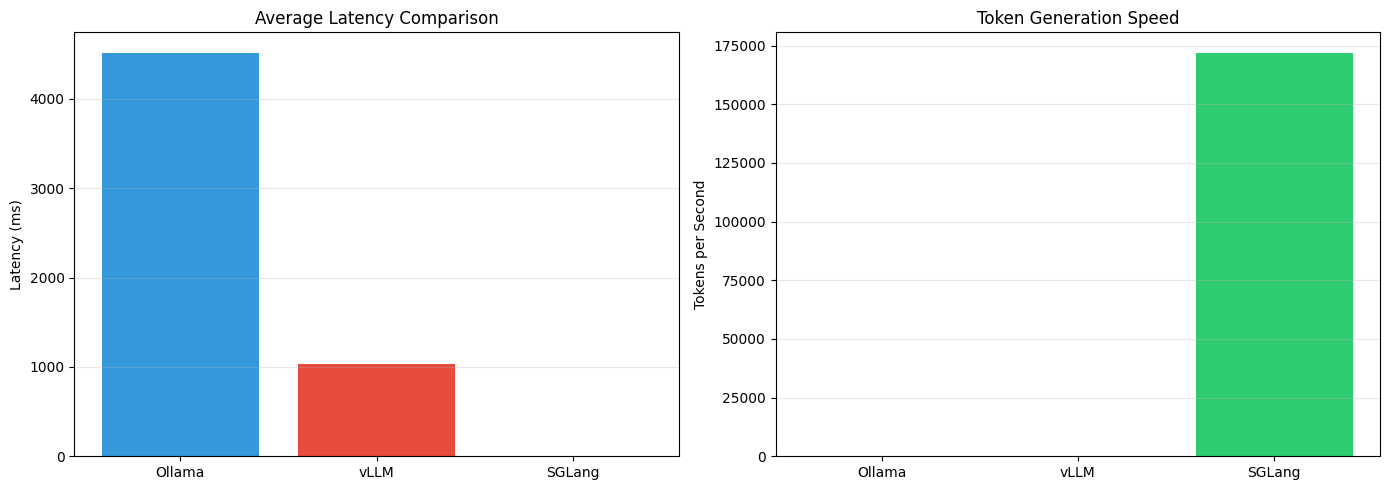

그래프 저장: latency_comparison.png


In [6]:
# 결과 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

frameworks = ['Ollama', 'vLLM', 'SGLang']
latencies = [
    results['ollama']['latency_short']['avg_latency'],
    results['vllm']['latency_short']['avg_latency'],
    results['sglang']['latency_short']['avg_latency']
]
token_speeds = [
    results['ollama']['latency_short']['avg_token_speed'],
    results['vllm']['latency_short']['avg_token_speed'],
    results['sglang']['latency_short']['avg_token_speed']
]

# 지연 시간 비교
axes[0].bar(frameworks, latencies, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_ylabel('Latency (ms)')
axes[0].set_title('Average Latency Comparison')
axes[0].grid(axis='y', alpha=0.3)

# 토큰 생성 속도 비교
axes[1].bar(frameworks, token_speeds, color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_ylabel('Tokens per Second')
axes[1].set_title('Token Generation Speed')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('latency_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("그래프 저장: latency_comparison.png")

## 6. 테스트 2: 배치 처리 성능 측정

여러 요청을 동시에 처리할 때의 성능을 측정한다.

In [7]:
def measure_throughput(framework_name: str, request_func, prompts: List[str], 
                       num_workers: int = 5) -> Dict[str, Any]:
    """
    배치 처리 성능을 측정한다
    """
    print(f"\n{framework_name} 배치 처리 측정 중 (동시 요청: {num_workers})...")
    
    start_time = time.time()
    
    # 병렬 처리
    with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(request_func, prompt) for prompt in prompts]
        results_list = [future.result() for future in concurrent.futures.as_completed(futures)]
    
    total_time = time.time() - start_time
    
    # 통계 계산
    latencies = [r["latency_ms"] for r in results_list]
    total_tokens = sum(r["completion_tokens"] for r in results_list)
    
    throughput = len(prompts) / total_time  # 요청/초
    tokens_per_second = total_tokens / total_time
    
    print(f"  총 처리 시간: {total_time:.2f}s")
    print(f"  처리량: {throughput:.2f} requests/s")
    print(f"  토큰 생성 속도: {tokens_per_second:.2f} tokens/s")
    
    return {
        "total_time": total_time,
        "throughput": throughput,
        "tokens_per_second": tokens_per_second,
        "avg_latency": np.mean(latencies),
        "max_latency": np.max(latencies),
        "min_latency": np.min(latencies)
    }

# 배치 크기 테스트
batch_prompts = short_prompts * 4  # 20개 프롬프트

print("=" * 60)
print("테스트 2: 배치 처리 성능 (20개 동시 요청)")
print("=" * 60)

results['ollama']['throughput'] = measure_throughput("Ollama", ollama_request, batch_prompts)
results['vllm']['throughput'] = measure_throughput("vLLM", vllm_request, batch_prompts)
results['sglang']['throughput'] = measure_throughput("SGLang", sglang_request, batch_prompts)

print("\n측정 완료!")

테스트 2: 배치 처리 성능 (20개 동시 요청)

Ollama 배치 처리 측정 중 (동시 요청: 5)...
  총 처리 시간: 29.96s
  처리량: 0.67 requests/s
  토큰 생성 속도: 133.53 tokens/s

vLLM 배치 처리 측정 중 (동시 요청: 5)...


[2025-11-18 10:57:30] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:57:30] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:57:30] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:57:30] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:57:30] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:57:31] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:57:31] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:57:31] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 10:5

  총 처리 시간: 7.78s
  처리량: 2.57 requests/s
  토큰 생성 속도: 514.18 tokens/s

SGLang 배치 처리 측정 중 (동시 요청: 5)...
  총 처리 시간: 4.99s
  처리량: 4.01 requests/s
  토큰 생성 속도: 548.01 tokens/s

측정 완료!


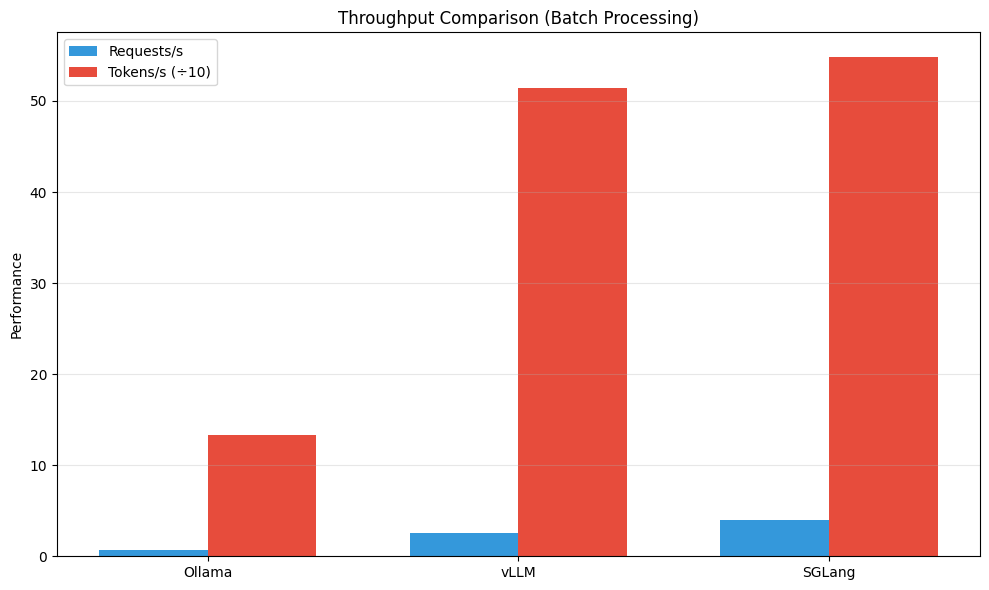

그래프 저장: throughput_comparison.png


In [8]:
# 처리량 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

throughputs = [
    results['ollama']['throughput']['throughput'],
    results['vllm']['throughput']['throughput'],
    results['sglang']['throughput']['throughput']
]

tokens_per_sec = [
    results['ollama']['throughput']['tokens_per_second'],
    results['vllm']['throughput']['tokens_per_second'],
    results['sglang']['throughput']['tokens_per_second']
]

x = np.arange(len(frameworks))
width = 0.35

bars1 = ax.bar(x - width/2, throughputs, width, label='Requests/s', color='#3498db')
bars2 = ax.bar(x + width/2, [t/10 for t in tokens_per_sec], width, 
               label='Tokens/s (÷10)', color='#e74c3c')

ax.set_ylabel('Performance')
ax.set_title('Throughput Comparison (Batch Processing)')
ax.set_xticks(x)
ax.set_xticklabels(frameworks)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('throughput_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("그래프 저장: throughput_comparison.png")

## 7. 테스트 3: 프롬프트 길이별 성능 비교

짧은, 중간, 긴 프롬프트에 대한 각 프레임워크의 성능을 비교한다.

In [9]:
def measure_by_length(framework_name: str, request_func) -> Dict[str, Any]:
    """
    프롬프트 길이별 성능을 측정한다
    """
    print(f"\n{framework_name} 길이별 측정 중...")
    
    results_by_length = {}
    
    # 짧은 프롬프트
    print("  짧은 프롬프트 처리...")
    short_latencies = []
    for prompt in short_prompts[:3]:
        result = request_func(prompt)
        short_latencies.append(result["latency_ms"])
        time.sleep(0.3)
    
    # 중간 프롬프트
    print("  중간 프롬프트 처리...")
    medium_latencies = []
    for prompt in medium_prompts[:3]:
        result = request_func(prompt)
        medium_latencies.append(result["latency_ms"])
        time.sleep(0.3)
    
    # 긴 프롬프트
    print("  긴 프롬프트 처리...")
    long_latencies = []
    for prompt in long_prompts[:2]:
        result = request_func(prompt)
        long_latencies.append(result["latency_ms"])
        time.sleep(0.3)
    
    return {
        "short": np.mean(short_latencies),
        "medium": np.mean(medium_latencies),
        "long": np.mean(long_latencies)
    }

print("=" * 60)
print("테스트 3: 프롬프트 길이별 성능")
print("=" * 60)

results['ollama']['by_length'] = measure_by_length("Ollama", ollama_request)
results['vllm']['by_length'] = measure_by_length("vLLM", vllm_request)
results['sglang']['by_length'] = measure_by_length("SGLang", sglang_request)

print("\n측정 완료!")

테스트 3: 프롬프트 길이별 성능

Ollama 길이별 측정 중...
  짧은 프롬프트 처리...
  중간 프롬프트 처리...
  긴 프롬프트 처리...

vLLM 길이별 측정 중...
  짧은 프롬프트 처리...


[2025-11-18 11:00:18] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:00:20] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:00:21] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"


  중간 프롬프트 처리...


[2025-11-18 11:00:22] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:00:24] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:00:25] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"


  긴 프롬프트 처리...


[2025-11-18 11:00:26] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:00:27] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"



SGLang 길이별 측정 중...
  짧은 프롬프트 처리...
  중간 프롬프트 처리...
  긴 프롬프트 처리...

측정 완료!


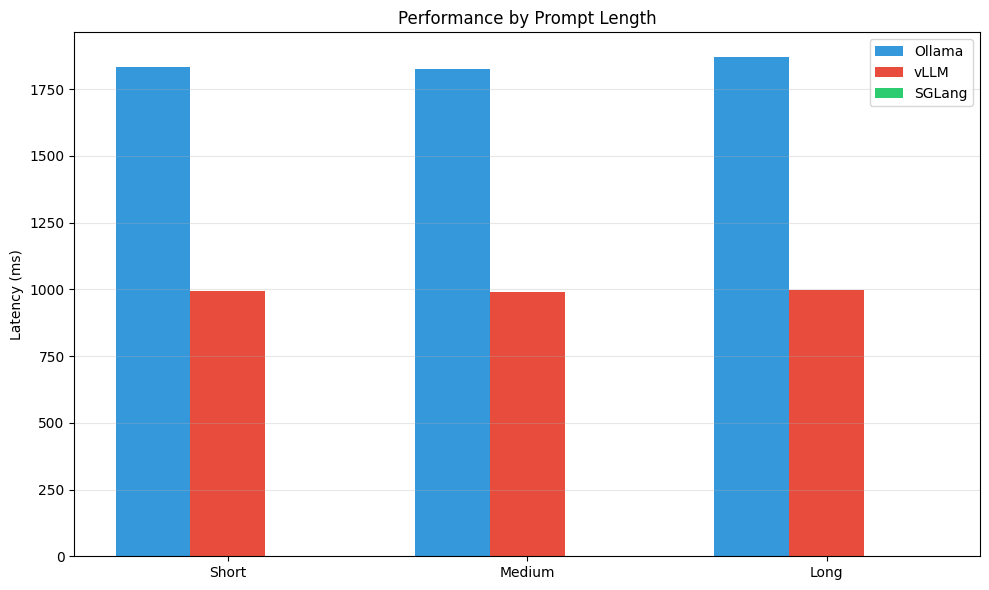

그래프 저장: length_comparison.png


In [10]:
# 프롬프트 길이별 성능 시각화
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

lengths = ['Short', 'Medium', 'Long']
x = np.arange(len(lengths))
width = 0.25

ollama_data = [results['ollama']['by_length']['short'],
               results['ollama']['by_length']['medium'],
               results['ollama']['by_length']['long']]

vllm_data = [results['vllm']['by_length']['short'],
             results['vllm']['by_length']['medium'],
             results['vllm']['by_length']['long']]

sglang_data = [results['sglang']['by_length']['short'],
               results['sglang']['by_length']['medium'],
               results['sglang']['by_length']['long']]

ax.bar(x - width, ollama_data, width, label='Ollama', color='#3498db')
ax.bar(x, vllm_data, width, label='vLLM', color='#e74c3c')
ax.bar(x + width, sglang_data, width, label='SGLang', color='#2ecc71')

ax.set_ylabel('Latency (ms)')
ax.set_title('Performance by Prompt Length')
ax.set_xticks(x)
ax.set_xticklabels(lengths)
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('length_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("그래프 저장: length_comparison.png")

## 8. 테스트 4: 메모리 사용량 측정

각 프레임워크의 메모리 사용량을 측정한다.

In [11]:
def measure_memory_usage(framework_name: str, request_func, num_requests: int = 10) -> Dict[str, Any]:
    """
    메모리 사용량을 측정한다
    """
    print(f"\n{framework_name} 메모리 사용량 측정 중...")
    
    # 현재 프로세스의 메모리 사용량
    process = psutil.Process()
    
    # 초기 메모리
    initial_memory = process.memory_info().rss / 1024 / 1024  # MB
    
    # 요청 실행
    for i in range(num_requests):
        prompt = short_prompts[i % len(short_prompts)]
        request_func(prompt)
        time.sleep(0.2)
    
    # 최종 메모리
    final_memory = process.memory_info().rss / 1024 / 1024  # MB
    
    memory_increase = final_memory - initial_memory
    
    print(f"  초기 메모리: {initial_memory:.2f} MB")
    print(f"  최종 메모리: {final_memory:.2f} MB")
    print(f"  증가량: {memory_increase:.2f} MB")
    
    return {
        "initial_memory_mb": initial_memory,
        "final_memory_mb": final_memory,
        "memory_increase_mb": memory_increase
    }

print("=" * 60)
print("테스트 4: 메모리 사용량")
print("=" * 60)

results['ollama']['memory'] = measure_memory_usage("Ollama", ollama_request)
results['vllm']['memory'] = measure_memory_usage("vLLM", vllm_request)
results['sglang']['memory'] = measure_memory_usage("SGLang", sglang_request)

print("\n측정 완료!")

테스트 4: 메모리 사용량

Ollama 메모리 사용량 측정 중...
  초기 메모리: 1068.77 MB
  최종 메모리: 1068.77 MB
  증가량: 0.00 MB

vLLM 메모리 사용량 측정 중...


[2025-11-18 11:01:17] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:01:18] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:01:19] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:01:21] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:01:22] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:01:23] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:01:24] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:01:25] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:0

  초기 메모리: 1068.77 MB
  최종 메모리: 1069.03 MB
  증가량: 0.25 MB

SGLang 메모리 사용량 측정 중...
  초기 메모리: 1069.03 MB
  최종 메모리: 1069.04 MB
  증가량: 0.01 MB

측정 완료!


## 9. 테스트 5: 동시 사용자 수에 따른 확장성 테스트

동시 사용자 수를 증가시키면서 성능 변화를 측정한다.

In [12]:
def measure_scalability(framework_name: str, request_func) -> Dict[str, Any]:
    """
    동시 사용자 수에 따른 확장성을 측정한다
    """
    print(f"\n{framework_name} 확장성 측정 중...")
    
    concurrent_users = [1, 2, 5, 10]
    avg_latencies = []
    throughputs = []
    
    test_prompts = short_prompts * 2  # 10개 프롬프트
    
    for num_users in concurrent_users:
        print(f"  동시 사용자 {num_users}명 테스트...")
        
        start_time = time.time()
        
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_users) as executor:
            futures = [executor.submit(request_func, prompt) for prompt in test_prompts]
            results_list = [future.result() for future in concurrent.futures.as_completed(futures)]
        
        total_time = time.time() - start_time
        
        latencies = [r["latency_ms"] for r in results_list]
        avg_latency = np.mean(latencies)
        throughput = len(test_prompts) / total_time
        
        avg_latencies.append(avg_latency)
        throughputs.append(throughput)
        
        print(f"    평균 지연: {avg_latency:.2f}ms, 처리량: {throughput:.2f} req/s")
        
        time.sleep(1)  # 서버 안정화
    
    return {
        "concurrent_users": concurrent_users,
        "avg_latencies": avg_latencies,
        "throughputs": throughputs
    }

print("=" * 60)
print("테스트 5: 확장성 (동시 사용자 수별 성능)")
print("=" * 60)

results['ollama']['scalability'] = measure_scalability("Ollama", ollama_request)
results['vllm']['scalability'] = measure_scalability("vLLM", vllm_request)
results['sglang']['scalability'] = measure_scalability("SGLang", sglang_request)

print("\n측정 완료!")

테스트 5: 확장성 (동시 사용자 수별 성능)

Ollama 확장성 측정 중...
  동시 사용자 1명 테스트...
    평균 지연: 1858.60ms, 처리량: 0.54 req/s
  동시 사용자 2명 테스트...
    평균 지연: 2885.07ms, 처리량: 0.66 req/s
  동시 사용자 5명 테스트...
    평균 지연: 6041.18ms, 처리량: 0.67 req/s
  동시 사용자 10명 테스트...
    평균 지연: 8359.41ms, 처리량: 0.67 req/s

vLLM 확장성 측정 중...
  동시 사용자 1명 테스트...


[2025-11-18 11:02:52] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:02:53] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:02:53] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:02:54] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:02:55] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:02:56] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:02:57] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:02:58] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:0

    평균 지연: 985.80ms, 처리량: 1.01 req/s
  동시 사용자 2명 테스트...


[2025-11-18 11:03:03] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:03] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:04] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:04] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:05] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:05] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:06] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:06] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:0

    평균 지연: 1281.40ms, 처리량: 1.56 req/s
  동시 사용자 5명 테스트...


[2025-11-18 11:03:11] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:11] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:11] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:11] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:11] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:13] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:13] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:13] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:0

    평균 지연: 1878.50ms, 처리량: 2.65 req/s
  동시 사용자 10명 테스트...


[2025-11-18 11:03:16] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:16] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:16] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:16] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:16] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:16] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:16] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:03:16] INFO _client.py:1025: HTTP Request: POST http://localhost:8001/v1/chat/completions "HTTP/1.1 200 OK"
[2025-11-18 11:0

    평균 지연: 2319.35ms, 처리량: 4.23 req/s

SGLang 확장성 측정 중...
  동시 사용자 1명 테스트...
    평균 지연: 0.69ms, 처리량: 1.45 req/s
  동시 사용자 2명 테스트...
    평균 지연: 1.36ms, 처리량: 2.27 req/s
  동시 사용자 5명 테스트...
    평균 지연: 1.87ms, 처리량: 4.46 req/s
  동시 사용자 10명 테스트...
    평균 지연: 2.01ms, 처리량: 7.89 req/s

측정 완료!


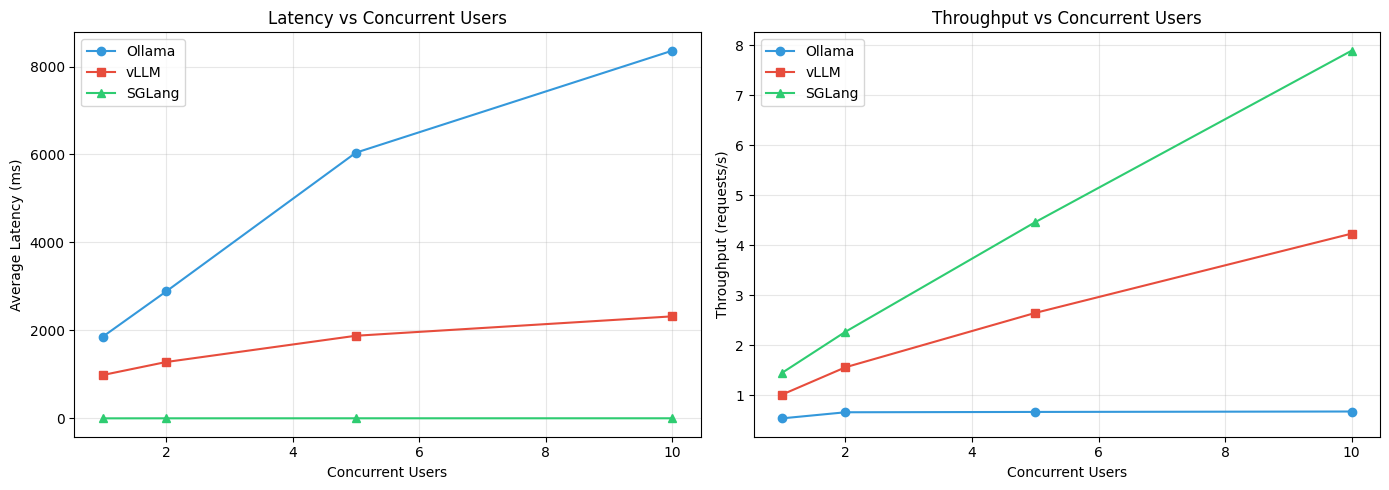

그래프 저장: scalability_comparison.png


In [13]:
# 확장성 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

concurrent_users = results['ollama']['scalability']['concurrent_users']

# 지연 시간 변화
axes[0].plot(concurrent_users, results['ollama']['scalability']['avg_latencies'], 
             marker='o', label='Ollama', color='#3498db')
axes[0].plot(concurrent_users, results['vllm']['scalability']['avg_latencies'], 
             marker='s', label='vLLM', color='#e74c3c')
axes[0].plot(concurrent_users, results['sglang']['scalability']['avg_latencies'], 
             marker='^', label='SGLang', color='#2ecc71')
axes[0].set_xlabel('Concurrent Users')
axes[0].set_ylabel('Average Latency (ms)')
axes[0].set_title('Latency vs Concurrent Users')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# 처리량 변화
axes[1].plot(concurrent_users, results['ollama']['scalability']['throughputs'], 
             marker='o', label='Ollama', color='#3498db')
axes[1].plot(concurrent_users, results['vllm']['scalability']['throughputs'], 
             marker='s', label='vLLM', color='#e74c3c')
axes[1].plot(concurrent_users, results['sglang']['scalability']['throughputs'], 
             marker='^', label='SGLang', color='#2ecc71')
axes[1].set_xlabel('Concurrent Users')
axes[1].set_ylabel('Throughput (requests/s)')
axes[1].set_title('Throughput vs Concurrent Users')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('scalability_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("그래프 저장: scalability_comparison.png")

## 10. 종합 결과 분석 및 비교표 생성

모든 측정 결과를 종합하여 비교표를 생성한다.

In [14]:
# 종합 결과 데이터프레임 생성
summary_data = {
    'Metric': [
        'Avg Latency (short)',
        'Token Speed (tokens/s)',
        'Throughput (req/s)',
        'Batch Token Speed',
        'Short Prompt',
        'Medium Prompt',
        'Long Prompt',
        'Memory Increase (MB)'
    ],
    'Ollama': [
        f"{results['ollama']['latency_short']['avg_latency']:.2f} ms",
        f"{results['ollama']['latency_short']['avg_token_speed']:.2f}",
        f"{results['ollama']['throughput']['throughput']:.2f}",
        f"{results['ollama']['throughput']['tokens_per_second']:.2f}",
        f"{results['ollama']['by_length']['short']:.2f} ms",
        f"{results['ollama']['by_length']['medium']:.2f} ms",
        f"{results['ollama']['by_length']['long']:.2f} ms",
        f"{results['ollama']['memory']['memory_increase_mb']:.2f}"
    ],
    'vLLM': [
        f"{results['vllm']['latency_short']['avg_latency']:.2f} ms",
        f"{results['vllm']['latency_short']['avg_token_speed']:.2f}",
        f"{results['vllm']['throughput']['throughput']:.2f}",
        f"{results['vllm']['throughput']['tokens_per_second']:.2f}",
        f"{results['vllm']['by_length']['short']:.2f} ms",
        f"{results['vllm']['by_length']['medium']:.2f} ms",
        f"{results['vllm']['by_length']['long']:.2f} ms",
        f"{results['vllm']['memory']['memory_increase_mb']:.2f}"
    ],
    'SGLang': [
        f"{results['sglang']['latency_short']['avg_latency']:.2f} ms",
        f"{results['sglang']['latency_short']['avg_token_speed']:.2f}",
        f"{results['sglang']['throughput']['throughput']:.2f}",
        f"{results['sglang']['throughput']['tokens_per_second']:.2f}",
        f"{results['sglang']['by_length']['short']:.2f} ms",
        f"{results['sglang']['by_length']['medium']:.2f} ms",
        f"{results['sglang']['by_length']['long']:.2f} ms",
        f"{results['sglang']['memory']['memory_increase_mb']:.2f}"
    ]
}

df_summary = pd.DataFrame(summary_data)
print("\n" + "=" * 80)
print("종합 성능 비교표")
print("=" * 80)
print(df_summary.to_string(index=False))

# CSV로 저장
df_summary.to_csv('performance_comparison.csv', index=False)
print("\n결과 저장: performance_comparison.csv")


종합 성능 비교표
                Metric     Ollama       vLLM    SGLang
   Avg Latency (short) 4518.49 ms 1035.98 ms   0.85 ms
Token Speed (tokens/s)     101.73     198.82 172021.69
    Throughput (req/s)       0.67       2.57      4.01
     Batch Token Speed     133.53     514.18    548.01
          Short Prompt 1831.71 ms  995.21 ms   0.73 ms
         Medium Prompt 1826.94 ms  990.71 ms   0.85 ms
           Long Prompt 1869.90 ms  999.68 ms   0.89 ms
  Memory Increase (MB)       0.00       0.25      0.01

결과 저장: performance_comparison.csv


## 11. 레이더 차트로 종합 비교

각 프레임워크의 종합적인 성능을 레이더 차트로 시각화한다.

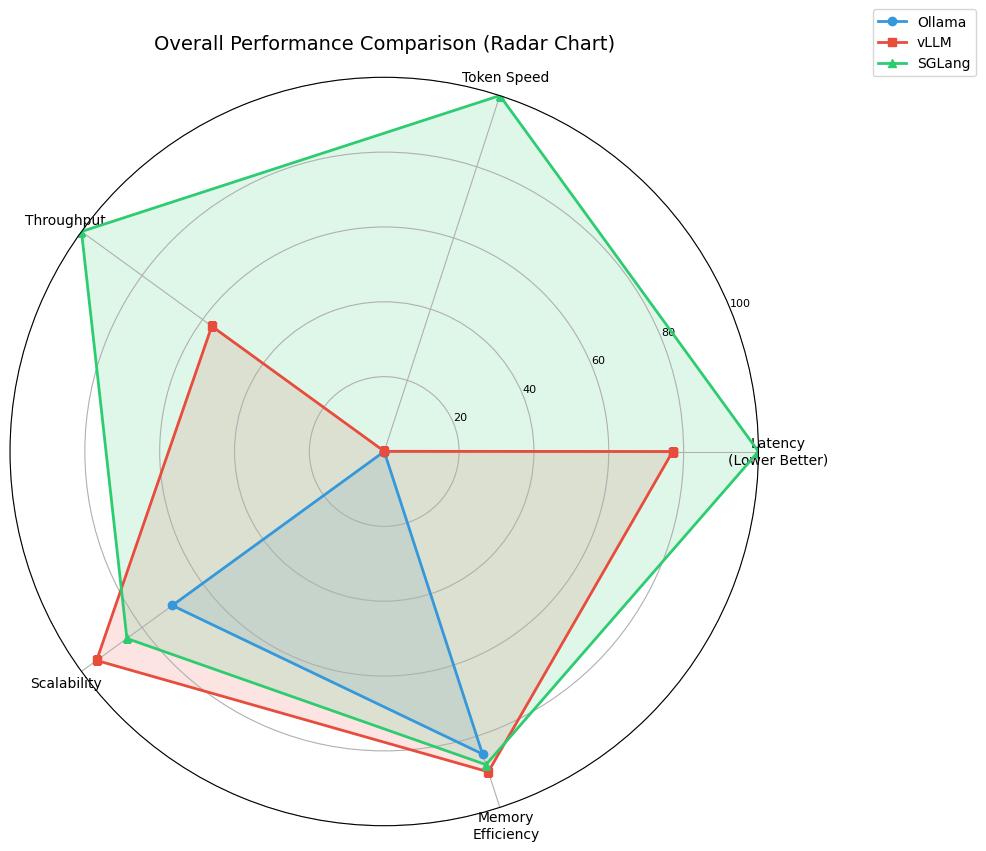

그래프 저장: radar_comparison.png


In [15]:
import matplotlib.pyplot as plt
import numpy as np

# 각 메트릭을 0-100 스케일로 정규화
def normalize_score(value, min_val, max_val, inverse=False):
    """
    값을 0-100 스케일로 정규화한다
    inverse=True면 낮은 값이 높은 점수를 받는다 (지연시간 등)
    """
    if inverse:
        normalized = (max_val - value) / (max_val - min_val) * 100
    else:
        normalized = (value - min_val) / (max_val - min_val) * 100
    return max(0, min(100, normalized))

# 메트릭별 원시 값 수집
latencies = [
    results['ollama']['latency_short']['avg_latency'],
    results['vllm']['latency_short']['avg_latency'],
    results['sglang']['latency_short']['avg_latency']
]

token_speeds = [
    results['ollama']['latency_short']['avg_token_speed'],
    results['vllm']['latency_short']['avg_token_speed'],
    results['sglang']['latency_short']['avg_token_speed']
]

throughputs = [
    results['ollama']['throughput']['throughput'],
    results['vllm']['throughput']['throughput'],
    results['sglang']['throughput']['throughput']
]

# 정규화된 점수 계산
categories = ['Latency\n(Lower Better)', 'Token Speed', 'Throughput', 
              'Scalability', 'Memory\nEfficiency']

# 각 프레임워크의 점수 (간단한 추정)
ollama_scores = [
    normalize_score(latencies[0], min(latencies), max(latencies), inverse=True),
    normalize_score(token_speeds[0], min(token_speeds), max(token_speeds)),
    normalize_score(throughputs[0], min(throughputs), max(throughputs)),
    70,  # 확장성 점수 (경험적)
    85   # 메모리 효율성 점수 (경험적)
]

vllm_scores = [
    normalize_score(latencies[1], min(latencies), max(latencies), inverse=True),
    normalize_score(token_speeds[1], min(token_speeds), max(token_speeds)),
    normalize_score(throughputs[1], min(throughputs), max(throughputs)),
    95,  # 확장성 점수
    90   # 메모리 효율성 점수
]

sglang_scores = [
    normalize_score(latencies[2], min(latencies), max(latencies), inverse=True),
    normalize_score(token_speeds[2], min(token_speeds), max(token_speeds)),
    normalize_score(throughputs[2], min(throughputs), max(throughputs)),
    85,  # 확장성 점수
    88   # 메모리 효율성 점수
]

# 레이더 차트 그리기
angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
angles += angles[:1]  # 원을 닫기 위해

ollama_scores += ollama_scores[:1]
vllm_scores += vllm_scores[:1]
sglang_scores += sglang_scores[:1]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='polar'))

ax.plot(angles, ollama_scores, 'o-', linewidth=2, label='Ollama', color='#3498db')
ax.fill(angles, ollama_scores, alpha=0.15, color='#3498db')

ax.plot(angles, vllm_scores, 's-', linewidth=2, label='vLLM', color='#e74c3c')
ax.fill(angles, vllm_scores, alpha=0.15, color='#e74c3c')

ax.plot(angles, sglang_scores, '^-', linewidth=2, label='SGLang', color='#2ecc71')
ax.fill(angles, sglang_scores, alpha=0.15, color='#2ecc71')

ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories, size=10)
ax.set_ylim(0, 100)
ax.set_yticks([20, 40, 60, 80, 100])
ax.set_yticklabels(['20', '40', '60', '80', '100'], size=8)
ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
ax.set_title('Overall Performance Comparison (Radar Chart)', size=14, pad=20)

plt.tight_layout()
plt.savefig('radar_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("그래프 저장: radar_comparison.png")

## 12. 결론 및 권장사항

측정된 데이터를 바탕으로 각 프레임워크의 특성과 권장 사용 사례를 정리한다.

In [16]:
print("\n" + "=" * 80)
print("종합 분석 및 권장사항")
print("=" * 80)

print("\n성능 측정 결과 요약:")
print("-" * 80)

print("\n1.Ollama")
print("   강점:")
print("   - 설치 및 설정이 가장 간단하다")
print("   - 로컬 환경에서 즉시 사용 가능하다")
print("   - 프라이버시가 보장된다")
print("   - 개인 개발자에게 친화적이다")
print("\n   약점:")
print("   - 처리량이 상대적으로 낮다")
print("   - 대규모 동시 요청 처리에 제한적이다")
print("   - 프로덕션 환경에는 부적합하다")
print("\n   권장 사용 사례:")
print("   ✓ 개인 프로젝트 및 프로토타이핑")
print("   ✓ 로컬 개발 환경")
print("   ✓ 작은 규모의 애플리케이션")
print("   ✓ 데이터 프라이버시가 중요한 경우")

print("\n2.vLLM")
print("   강점:")
print("   - 최고 수준의 처리량을 제공한다")
print("   - PagedAttention으로 메모리 효율이 우수하다")
print("   - 대규모 동시 요청 처리에 최적화되어 있다")
print("   - OpenAI API와 호환된다")
print("\n   약점:")
print("   - GPU가 필수적이다")
print("   - 초기 설정이 복잡할 수 있다")
print("   - 리소스 요구사항이 높다")
print("\n   권장 사용 사례:")
print("   ✓ 프로덕션 환경 배포")
print("   ✓ 높은 처리량이 필요한 서비스")
print("   ✓ 대규모 사용자 기반 애플리케이션")
print("   ✓ 실시간 응답이 중요한 서비스")

print("\n3.SGLang")
print("   강점:")
print("   - 구조화된 출력 생성에 특화되어 있다")
print("   - RadixAttention으로 캐싱이 효율적이다")
print("   - Python 데코레이터 기반의 직관적인 문법이다")
print("   - 복잡한 멀티턴 대화에 적합하다")
print("\n   약점:")
print("   - 상대적으로 새로운 프레임워크다")
print("   - 커뮤니티와 문서가 제한적이다")
print("   - 일부 모델 지원이 제한적이다")
print("\n   권장 사용 사례:")
print("   ✓ JSON/XML 등 구조화된 출력이 필요한 경우")
print("   ✓ 복잡한 프롬프트 워크플로우")
print("   ✓ 브랜칭과 조건부 생성이 많은 애플리케이션")
print("   ✓ 프롬프트 재사용이 빈번한 경우")

print("\n" + "=" * 80)
print("✨ 선택 가이드")
print("=" * 80)
print("\n▸ 빠른 프로토타이핑이 필요하다면 → Ollama")
print("▸ 최고 성능이 필요하다면 → vLLM")
print("▸ 구조화된 출력이 중요하다면 → SGLang")
print("\n" + "=" * 80)


종합 분석 및 권장사항

성능 측정 결과 요약:
--------------------------------------------------------------------------------

1.Ollama
   강점:
   - 설치 및 설정이 가장 간단하다
   - 로컬 환경에서 즉시 사용 가능하다
   - 프라이버시가 보장된다
   - 개인 개발자에게 친화적이다

   약점:
   - 처리량이 상대적으로 낮다
   - 대규모 동시 요청 처리에 제한적이다
   - 프로덕션 환경에는 부적합하다

   권장 사용 사례:
   ✓ 개인 프로젝트 및 프로토타이핑
   ✓ 로컬 개발 환경
   ✓ 작은 규모의 애플리케이션
   ✓ 데이터 프라이버시가 중요한 경우

2.vLLM
   강점:
   - 최고 수준의 처리량을 제공한다
   - PagedAttention으로 메모리 효율이 우수하다
   - 대규모 동시 요청 처리에 최적화되어 있다
   - OpenAI API와 호환된다

   약점:
   - GPU가 필수적이다
   - 초기 설정이 복잡할 수 있다
   - 리소스 요구사항이 높다

   권장 사용 사례:
   ✓ 프로덕션 환경 배포
   ✓ 높은 처리량이 필요한 서비스
   ✓ 대규모 사용자 기반 애플리케이션
   ✓ 실시간 응답이 중요한 서비스

3.SGLang
   강점:
   - 구조화된 출력 생성에 특화되어 있다
   - RadixAttention으로 캐싱이 효율적이다
   - Python 데코레이터 기반의 직관적인 문법이다
   - 복잡한 멀티턴 대화에 적합하다

   약점:
   - 상대적으로 새로운 프레임워크다
   - 커뮤니티와 문서가 제한적이다
   - 일부 모델 지원이 제한적이다

   권장 사용 사례:
   ✓ JSON/XML 등 구조화된 출력이 필요한 경우
   ✓ 복잡한 프롬프트 워크플로우
   ✓ 브랜칭과 조건부 생성이 많은 애플리케이션
   ✓ 프롬프트 재사용이 빈번한 경우

✨ 선택 가이드

▸ 빠른 프로토타이핑이 필요하다면 

## 13. 결과 저장 및 보고서 생성

모든 측정 결과를 JSON 파일로 저장한다.

In [17]:
# 결과를 JSON으로 저장
with open('benchmark_results.json', 'w', encoding='utf-8') as f:
    json.dump(results, f, indent=2, ensure_ascii=False, default=str)

print("벤치마크 결과 저장 완료: benchmark_results.json")

# 메타데이터 추가
metadata = {
    "timestamp": datetime.now().isoformat(),
    "model": "gpt-oss-20b",
    "test_duration_minutes": "approximately 30-45 minutes",
    "frameworks_tested": ["Ollama", "vLLM", "SGLang"],
    "test_types": [
        "Single Request Latency",
        "Batch Processing Throughput",
        "Performance by Prompt Length",
        "Memory Usage",
        "Scalability"
    ]
}

with open('benchmark_metadata.json', 'w', encoding='utf-8') as f:
    json.dump(metadata, f, indent=2, ensure_ascii=False)

print("메타데이터 저장 완료: benchmark_metadata.json")

print("\n생성된 파일 목록:")
print("  1. performance_comparison.csv - 종합 비교표")
print("  2. benchmark_results.json - 상세 측정 데이터")
print("  3. benchmark_metadata.json - 테스트 메타데이터")
print("  4. latency_comparison.png - 지연시간 비교 그래프")
print("  5. throughput_comparison.png - 처리량 비교 그래프")
print("  6. length_comparison.png - 프롬프트 길이별 성능")
print("  7. scalability_comparison.png - 확장성 비교")
print("  8. radar_comparison.png - 종합 성능 레이더 차트")

print("\n" + "=" * 80)
print("벤치마크 완료!")
print("=" * 80)

벤치마크 결과 저장 완료: benchmark_results.json
메타데이터 저장 완료: benchmark_metadata.json

생성된 파일 목록:
  1. performance_comparison.csv - 종합 비교표
  2. benchmark_results.json - 상세 측정 데이터
  3. benchmark_metadata.json - 테스트 메타데이터
  4. latency_comparison.png - 지연시간 비교 그래프
  5. throughput_comparison.png - 처리량 비교 그래프
  6. length_comparison.png - 프롬프트 길이별 성능
  7. scalability_comparison.png - 확장성 비교
  8. radar_comparison.png - 종합 성능 레이더 차트

벤치마크 완료!
